# CNN with Brain Cell Images

Nicholas Larsen
Steven Larsen

This data came from real world microscopic images.  Each image is a blood smear from a patient that was then placed on a slide for imaging.  This data was collected with the intention of classifing Acute Lymphoblastic Leukemia (ALL).  This can be a difficult task in, due to the differences between healthy and cells with leukemia being extremely small.  Each image from the data set was analyzed by an expert oncologist.  


# Load images, show a few examples

In [1]:
from PIL import Image
from os import listdir
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
from skimage.io import imshow
from ipywidgets import widgets  # make this interactive!
from ipywidgets import fixed
import copy
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import make_scorer, accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

def gray_sacle(data):
    return np.dot(data[...,:3], [0.299, 0.587, 0.114])

def read_images(directories, grey_scale=False, verb = False):
    """Reads in the all and rem directoires under each directory in the list directories"""
    X = []
    y = []
    for direct in dirs:
        if verb:
            print(f"Reading {direct}")
        direct_all = f"{direct}\\all"
        for file in listdir(direct_all):
            if verb:
                print(f"Reading file: {file}")
            image = Image.open(f"{direct_all}\\{file}")
            data = np.asarray(image)
            if grey_scale:
                data = gray_sacle(data)
            #data = data.ravel()
            X.append(data)
            y.append(1)
                
        direct_rem = f"{direct}\\hem"
        for file in listdir(direct_rem):
            if verb:
                print(f"Reading file: {file}")
            image = Image.open(f"{direct_rem}\\{file}")
            data = np.asarray(image)
            if grey_scale:
                data = gray_sacle(data)
            #data = data.ravel()
            X.append(data)
            y.append(0)
                
    return np.asarray(X), np.asarray(y)

def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i],cmap='bone')
    plt.show()

In [2]:
%%time
dirs = [
    r'..\archive\C-NMC_Leukemia\training_data\fold_0',
    r'..\archive\C-NMC_Leukemia\training_data\fold_1',
    r'..\archive\C-NMC_Leukemia\training_data\fold_2'
#    r'..\archive\C-NMC_Leukemia\training_data\fold_small'
]
X, y = read_images(dirs, verb=False)
print(X.shape)

(10655, 450, 450, 3)
Wall time: 1min 17s


In [3]:
y_0 = len(y[y==0])
y_1 = len(y[y==1])
print(len(y[y==0]), len(y[y==1]))
print(y_0/(y_1+y_0))

3383 7272
0.3175035194744252


## Trim images to only have the cell part

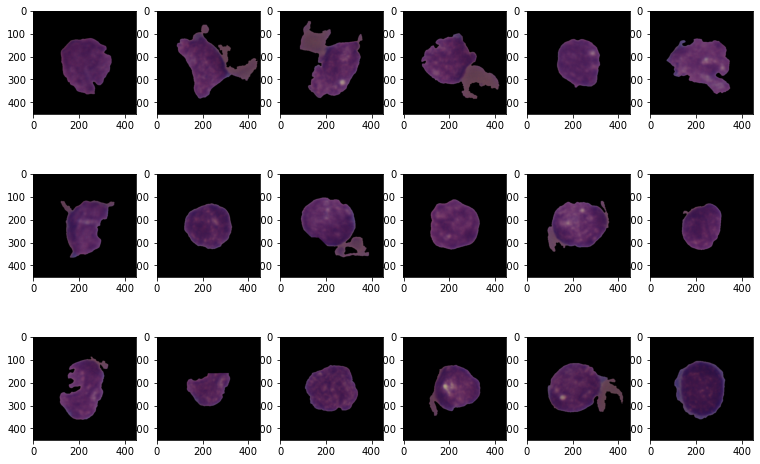

In [4]:
plot_gallery(X, [i for i  in range(0,18)], 450,450)

In [5]:
for idx, x in enumerate(range(7,10)):
    print(idx, x)

0 7
1 8
2 9


In [6]:
def get_img_extremes(img):
    min_row = 0
    max_row = 0

    for i in range(len(img)):
        s = np.sum(img[i])
        if min_row == 0 and s != 0:
            min_row = i
        if min_row != 0 and max_row < s:
            max_row = i

    max_col = 0
    min_col = 0
    for i in range(len(img)):
        s = np.sum(img[:,i])
        if min_col == 0 and s > 0:
            min_col = i
        if min_col != 0 and max_col < s:
            max_col = i
    return [min_row, max_row, min_col, max_col]

min_row = 449
max_row = 0
min_col = 449
max_col = 0
extss = []
for img in X:
    exts = get_img_extremes(img)
    extss.append(exts)
    min_row = min(exts[0] , min_row)
    max_row = max(exts[1] , max_row)
    min_col = min(exts[2] , min_col)
    max_col = max(exts[3] , max_col)

In [7]:
extss = np.array(extss)
min_row = int((np.mean(extss[:,0]) - np.std(extss[:,0])).round())
max_row = int((np.mean(extss[:,1]) + np.std(extss[:,1])).round())
min_col = int((np.mean(extss[:,2]) - np.std(extss[:,2])).round())
max_col = int((np.mean(extss[:,3]) + np.std(extss[:,3])).round())
print('Mean min_row:', min_row)
print('Mean max_row:', max_row)
print('Mean min_col:', min_col)
print('Mean max_col:', max_col)

Mean min_row: 101
Mean max_row: 349
Mean min_col: 100
Mean max_col: 350


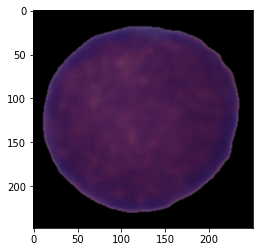

In [8]:
# example cropped image
WIDTH = max_col - min_col
HEIGHT = max_row - min_row
plt.imshow(img[min_row:max_row, min_col:max_col],cmap='bone')

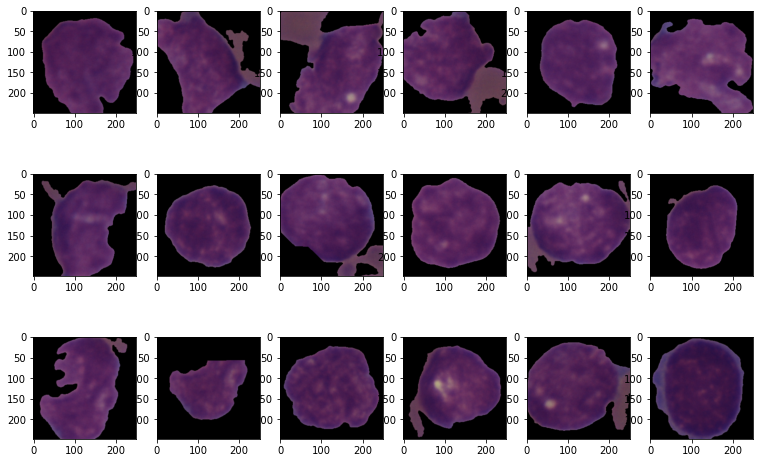

In [9]:
plot_gallery(X[:,min_row:max_row, min_col:max_col], h = HEIGHT, w = WIDTH, titles=[i for i  in range(0,18)])

In [10]:
X = X[:,min_row:max_row, min_col:max_col]

In [11]:
# Randomly cut dataset in half to make it more managable
# ONLY RUN ONCe
#SKIPPED
idxs = [i for i in range(len(X))]
idxs = np.random.choice(idxs, 2000)
X = X[idxs]
y = y[idxs]

y_0 = len(y[y==0])
y_1 = len(y[y==1])
print(len(y[y==0]), len(y[y==1]))
print(y_0/(y_1+y_0))

616 1384
0.308


# Define splitting Techniques (why is this realistic in practice)

Our data is going to be split into training and testing (80 / 20).  On the 80 we will perform stratified K folds.  This will just be used to compare the different models produced in this lab.

In [12]:
# Split the data
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape

(1600, 248, 250, 3)

## Normalize 

In [13]:
# Normilize the X
#X = X/255.0 - 0.5
#for col in numeric_headers:
#    df_train[col] = df_train[col].astype(np.float)
#    df_test[col] = df_test[col].astype(np.float)
#    
#    ss = StandardScaler()
#    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
#    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

X_train = np.copy(X_train)

for row in range(X_train.shape[1]):
    for col in range(X_train.shape[2]):
        ss = StandardScaler()
        X_train[:,row,col] = ss.fit_transform(X_train[:,row,col])
        X_test[:,row,col] = ss.transform(X_test[:,row,col])

# Preparation
## Explain Metrics

## Define splitting Techniques (why is this realistic in practice)

____

# Modeling

## Set up Data Expansion in Keras. 
### Options from town hall
* Data augmentation he showed an example of. Tends to be slow
* Go through and a couple of passes of expansion'
* Use expansion for a couple of epic at the end
### Reasoning

### Data Augmentation

### Data Augmentation

* Rotation: We are deciding not to perform any rotation on the images since the images are cells the orientations of them is likely to be pretty random and probably has a good distribution of orientations across the many samples the large dataset has. 
* Shifting: we will allow for shifting to prevent the location from of characteristics in the image from being memorized.
* We will allow it to flip either vertically or horizontally
* No scaling or color shifting will be preformed

In [16]:
print(X_train.shape, y_train.shape)

(1600, 248, 250, 3) (1600,)


In [17]:
datagen = None

In [18]:
%%time
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_epsilon= 0.,
    zca_whitening=False,
    rotation_range=0, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

datagen.fit(X_train)


Wall time: 592 ms


In [19]:
print(len(y[y==0]), len(y[y==1]))

616 1384


In [20]:
 print(len(y[y==0])/(len(y[y==1])+len(y[y==0]))*100)

30.8


(1, 248, 250, 3)


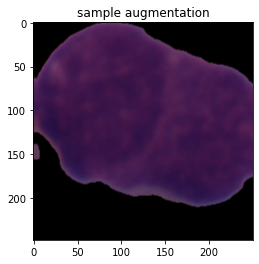

In [21]:
tmps = datagen.flow(X[[1,2]], X[[1,2]], batch_size=1)

for tmp in tmps:
    print(tmp[0].shape)
    plt.imshow(tmp[0].squeeze().astype(np.uint8))
    plt.title("sample augmentation")
    break
    

tmps = None

# This will turn the values into floats, to graph ints are required

## Create Convolutional Neural Network using Keras. 
* Investigate different parameters on at least two different network architectures
* Architectural Differences
 * Number of layers
 * Whether or not using residual paths
 * Seperable convolutions
 
Need a total of 4 models

____

In [22]:
print(X.shape, y.shape)
print(y.reshape(-1,1).shape)

(2000, 248, 250, 3) (2000,)
(2000, 1)


In [42]:
%%time
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.utils.class_weight import compute_class_weight


NUM_CLASSES = 2
img_wh = 450
channels = 3
def model_1_create(input_shape, num_filt_layers=[16, 32], kernal_size=(3,3)):
    cnn = Sequential()
    
    for num_filters in num_filt_layers:
        cnn.add( Conv2D(filters=num_filters, 
                        kernel_size=kernal_size, 
                        padding='same', 
                        activation='relu',
                        data_format="channels_last") ) # more compact syntax
    cnn.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_last") )
    
    # add one layer on flattened output
    cnn.add( Dropout(0.125) ) # add some dropout for regularization after conv layers
    cnn.add( Flatten() )
    cnn.add( Dense(256, activation='relu') )
    cnn.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
    cnn.add( Flatten() )
    cnn.add( Dense(128, activation='relu') )
    cnn.add( Dropout(0.5) ) # add some dropout for regularization, again!
    cnn.add( Dense(NUM_CLASSES, activation='softmax') )
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='rmsprop', # 'adadelta' 'rmsprop'
                  metrics=['accuracy',tf.keras.metrics.Recall(name='recall_score')])
    cnn.build(input_shape=input_shape)
    
    return cnn
    
    
def model_1_train(X_train, X_test, y_train, y_test, cnn, epochs=5):
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    #

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_epsilon= 0.,
        zca_whitening=False,
        rotation_range=0, # used, Int. Degree range for random rotations.
        width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
        height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
        shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)

    datagen.fit(X)
    
    # https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
    # got wieghts code from here ^
    y_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    
    # the flow method yields batches of images indefinitely, with the given transformations
    history = cnn.fit_generator(datagen.flow(X_train, y_train, batch_size=128), 
                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                       epochs=epochs, verbose=1, class_weight=d_class_weights,
                       validation_data=(X_test,y_test))

    return history, cnn

Wall time: 0 ns


In [43]:
model_1_nn = None
model_1_nn =  model_1_create(X_train.shape)
model_1_nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (1600, 248, 250, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (1600, 248, 250, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (1600, 124, 125, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (1600, 124, 125, 32)      0         
_________________________________________________________________
flatten_6 (Flatten)          (1600, 496000)            0         
_________________________________________________________________
dense_11 (Dense)             (1600, 256)               126976256 
_________________________________________________________________
dropout_12 (Dropout)         (1600, 256)              

In [44]:
%%time
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, stratify=y)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

c1 = np.sum(y_train_ohe[:, 0])
c2 = np.sum(y_train_ohe[:, 1])
print('Class 1:', c1, 'Class 2:', c2)
print('Class 1%:', c1/(c1+c2)*100)
print('Class 2%:', c2/(c1+c2)*100)

history, model_1_nn = model_1_train(X_train, X_test, y_train_ohe, y_test_ohe,
                                    model_1_nn, 5)

Class 1: 493.0 Class 2: 1107.0
Class 1%: 30.812498927116394
Class 2%: 69.18749809265137


C:\Users\Nick\.conda\envs\mlenv2020\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Nick\.conda\envs\mlenv2020\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
12/12 [==============================] - 53s 4s/step - loss: 157.8242 - accuracy: 0.5642 - recall_score: 0.5642 - val_loss: 2.6329 - val_accuracy: 0.8175 - val_recall_score: 0.8175
Epoch 2/5
12/12 [==============================] - 51s 4s/step - loss: 5.5416 - accuracy: 0.7023 - recall_score: 0.7023 - val_loss: 1.7658 - val_accuracy: 0.7900 - val_recall_score: 0.7900
Epoch 3/5
12/12 [==============================] - 51s 4s/step - loss: 3.0668 - accuracy: 0.7188 - recall_score: 0.7188 - val_loss: 0.6466 - val_accuracy: 0.8350 - val_recall_score: 0.8350
Epoch 4/5
12/12 [==============================] - 51s 4s/step - loss: 1.7818 - accuracy: 0.6827 - recall_score: 0.6827 - val_loss: 0.5073 - val_accuracy: 0.8100 - val_recall_score: 0.8100
Epoch 5/5
12/12 [==============================] - 51s 4s/step - loss: 1.0845 - accuracy: 0.7201 - recall_score: 0.7201 - val_loss: 0.5787 - val_accuracy: 0.7675 - val_recall_score: 0.7675
Wall time: 4min 20s


Text(0.5, 0, 'epochs')

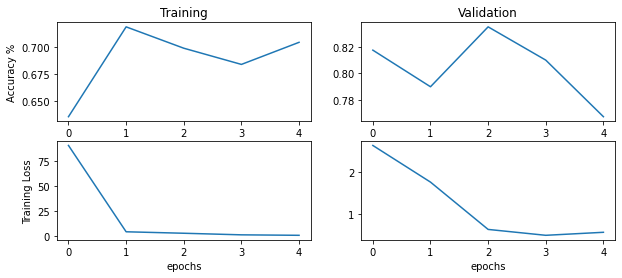

In [45]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['recall_score'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history.history['val_recall_score'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [46]:
yhat_per = model_1_nn.predict(X_test)
yhat = np.round(yhat_per)

In [47]:
print(mt.confusion_matrix(y_test,yhat[:,1].astype(np.uint8)))
print(mt.classification_report(y_test,yhat[:,1].astype(np.uint8)))

[[108  15]
 [ 78 199]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       123
           1       0.93      0.72      0.81       277

    accuracy                           0.77       400
   macro avg       0.76      0.80      0.75       400
weighted avg       0.82      0.77      0.78       400



In [27]:
print(len(y_train[y_train==0]), len(y_train[y_train==1]))

506 1094


In [51]:
np.sum(y_train_ohe[:, 0])

2706.0

In [52]:
np.sum(y_train_ohe[:, 1])

5818.0

## Visualize the final Results
* Visualize
* Compare statistically
* Compare the performance to a standard ML_P using the receiver operating characteristic and the area under the curve
This includes:
* Which one is the best
* Which one you should choose
* How might you deploy it
* All of the things you might be interested in

In [6]:
# Code here

# Use transfer learning to pre-train weights of your initial layers of CNN
* Compare to best other model
* There is an exmaple in his notebook. Use Img Net weights, VGG. Compare from scratch from above

In [ ]:
# Code here